If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [1]:
#! pip install datasets, transformers

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/token-classification).

# Fine-tuning a model on a token classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a token classification task, which is the task of predicting a label for each token.

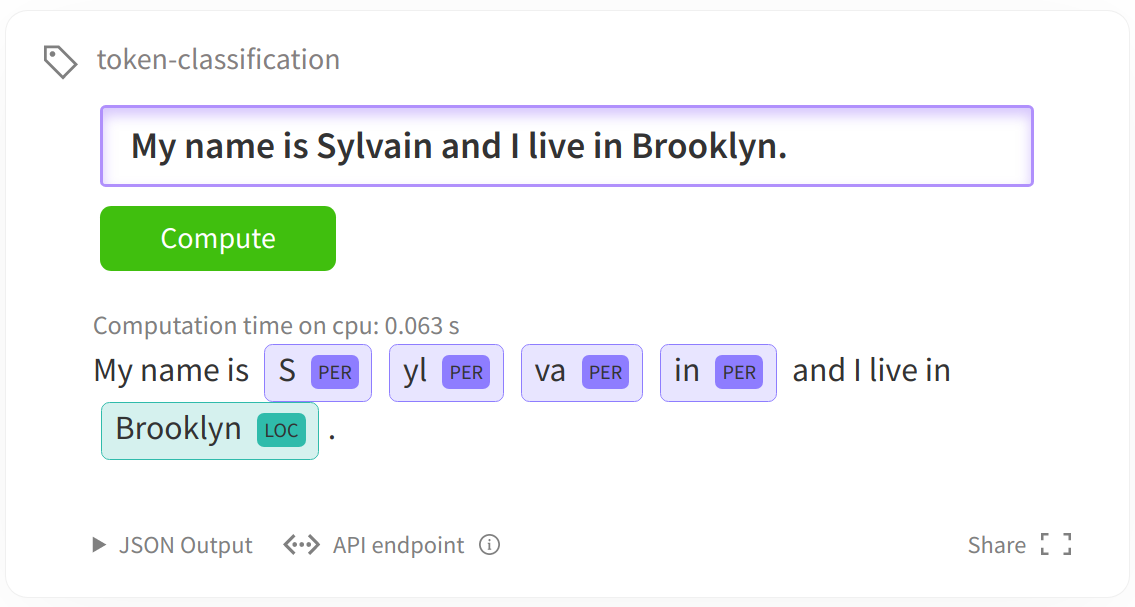

The most common token classification tasks are:

- NER (Named-entity recognition) Classify the entities in the text (person, organization, location...).
- POS (Part-of-speech tagging) Grammatically classify the tokens (noun, verb, adjective...)
- Chunk (Chunking) Grammatically classify the tokens and group them into "chunks" that go together

We will see how to easily load a dataset for these kinds of tasks and use the `Trainer` API to fine-tune a model on it.

This notebook is built to run on any token classification task, with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a token classification head and a fast tokenizer (check on [this table](https://huggingface.co/transformers/index.html#bigtable) if this is the case). It might just need some small adjustments if you decide to use a different dataset than the one used here. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [2]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [3]:
from datasets import load_dataset, load_metric

For our example here, we'll use the [CONLL 2003 dataset](https://www.aclweb.org/anthology/W03-0419.pdf). The notebook should work with any token classification dataset provided by the 🤗 Datasets library. If you're using your own dataset defined from a JSON or csv file (see the [Datasets documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) on how to load them), it might need some adjustments in the names of the columns used.

In [4]:
datasets = load_dataset("conll2003")

Reusing dataset conll2003 (/home/sgugger/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63ba56944e35c1943434322a07ceefd79864672041b7834583709af4a5de4664)


The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [5]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

We can see the training, validation and test sets all have a column for the tokens (the input texts split into words) and one column of labels for each kind of task we introduced before.

To access an actual element, you need to select a split first, then give an index:

In [6]:
datasets["train"][0]

{'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'id': '0',
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.']}

The labels are already coded as integer ids to be easily usable by our model, but the correspondence with the actual categories is stored in the `features` of the dataset:

In [7]:
datasets["train"].features[f"ner_tags"]

Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], names_file=None, id=None), length=-1, id=None)

So for the NER tags, 0 corresponds to 'O', 1 to 'B-PER' etc... On top of the 'O' (which means no special entity), there are four labels for NER here, each prefixed with 'B-' (for beginning) or 'I-' (for intermediate), that indicate if the token is the first one for the current group with the label or not:
- 'PER' for person
- 'ORG' for organization
- 'LOC' for location
- 'MISC' for miscellaneous

Since the labels are lists of `ClassLabel`, the actual names of the labels are nested in the `feature` attribute of the object above:

In [8]:
label_list = datasets["train"].features[f"{task}_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [9]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [10]:
show_random_elements(datasets["train"])

,chunk_tags,id,ner_tags,pos_tags,tokens
0,"[B-NP, B-NP, I-NP, I-NP]",2440,"[O, O, O, O]","[NNS, POS, CD, NNS]","[Women, 's, 400, metres]"
1,"[B-NP, I-NP, O, B-NP, I-NP, O, B-NP, I-NP, O, O, B-NP, I-NP]",925,"[B-PER, I-PER, O, B-PER, I-PER, O, B-LOC, I-LOC, O, O, B-PER, I-PER]","[NNP, NNP, ,, NNP, NNP, (, NNP, NNP, ), ,, NNP, NNP]","[Mark, Roe, ,, Retief, Goosen, (, South, Africa, ), ,, Carl, Suneson]"
2,"[B-NP, I-NP]",13421,"[B-LOC, O]","[NNP, CD]","[AMMAN, 1996-08-29]"
3,"[B-NP, I-NP, I-NP, I-NP, B-PP, B-NP, I-NP, B-VP, B-NP, I-NP, B-NP, I-NP, I-NP, B-NP, I-NP, I-NP, I-NP, I-NP, I-NP, I-NP, B-PP, B-NP, O]",2729,"[O, O, O, O, O, O, O, O, O, O, O, B-MISC, I-MISC, I-MISC, I-MISC, O, B-ORG, I-ORG, O, B-ORG, O, B-LOC, O]","[DT, JJ, CD, NNS, IN, DT, NN, VBP, JJ, NN, POS, NNP, NNS, POS, JJ, NNS, NNP, NNP, CC, NNP, IN, NNP, .]","[The, other, two, teams, in, the, group, are, last, season, 's, Cup, Winners, ', Cup, runners-up, Rapid, Vienna, and, Fenerbahce, of, Turkey, .]"
4,[B-NP],8022,[B-LOC],[NNP],[L-ORIZZONT]
5,"[B-NP, I-NP, I-NP, B-PP, B-NP, I-NP, B-NP, I-NP, I-NP, I-NP, B-VP, B-NP, I-NP, B-SBAR, B-NP, I-NP, B-NP, I-NP, B-VP, I-VP, B-ADJP, O]",7367,"[O, O, O, O, O, O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O]","[DT, NN, NN, IN, DT, NN, NN, NN, NNP, NNP, VBD, JJ, NNP, IN, DT, NNS, POS, NN, MD, VB, JJ, .]","[The, director, general, of, the, air, traffic, service, Valentin, Valkov, said, last, Friday, that, a, controllers, ', strike, would, be, illegal, .]"
6,"[B-NP, I-NP, O, B-NP, I-NP, O, B-VP, B-NP, I-NP, I-NP, I-NP, O, B-NP, I-NP, O, B-NP, I-NP, I-NP, I-NP]",10391,"[B-PER, I-PER, O, B-LOC, I-LOC, O, O, O, O, B-PER, I-PER, O, B-LOC, I-LOC, O, O, O, O, O]","[NNP, NNP, (, NNP, NNP, ), VB, CD, :, NNP, NNP, (, NNP, NNP, ), CD, CD, CD, CD]","[David, Nainkin, (, South, Africa, ), beat, 9, -, Wayne, Ferreira, (, South, Africa, ), 6-4, 6-4, 2-6, 7-5]"
7,"[B-NP, I-NP, I-NP, B-VP, I-VP, I-VP, I-VP, B-NP, I-NP, I-NP, B-NP, B-VP, B-ADJP, B-VP, I-VP, B-PP, B-NP, I-NP, O, B-NP, I-NP, I-NP, B-VP, B-PP, B-NP, I-NP, I-NP, B-VP, B-PRT, B-PP, B-NP, I-NP, B-PP, B-NP, B-PP, B-NP, B-PP, B-NP, B-VP, B-PP, B-NP, O, B-PP, B-NP, I-NP, I-NP, B-PP, B-NP, O]",5786,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, B-LOC, O, O, O, O, O, O, B-LOC, O]","[DT, JJ, NN, MD, VB, TO, VB, PDT, DT, NN, PRP, VBD, JJ, TO, VB, IN, DT, NN, ,, DT, NN, NN, VBD, IN, DT, JJ, NN, VBD, RP, IN, DT, NNP, IN, NNP, IN, NNP, IN, NNP, VBD, IN, NNP, ,, IN, DT, JJ, NN, IN, NNP, .]","[The, right-handed, batsman, will, have, to, forfeit, half, the, money, he, was, due, to, earn, from, the, tour, ,, the, news, agency, said, after, a, disciplinary, committee, set, up, by, the, Board, of, Control, for, Cricket, in, India, met, at, Mohali, ,, near, the, northern, city, of, Chandigarh, .]"
8,"[B-NP, B-VP, B-NP, B-VP, B-NP, I-NP, B-PP, B-NP, I-NP, O, B-SBAR, B-NP, B-VP, B-NP, I-NP, B-VP, B-NP, I-NP, O]",7633,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[PRP, VBD, EX, VBD, DT, NN, IN, JJ, NN, CC, IN, NNS, VBD, DT, NN, VBD, DT, NN, .]","[They, said, there, was, no, sign, of, foul, play, and, that, investigators, believed, the, death, was, a, suicide, .]"
9,"[B-NP, B-NP, I-NP, B-PP, B-NP, B-VP, B-NP, I-NP, O, B-VP, B-NP, B-PP, B-NP, I-NP, I-NP, B-NP, B-VP, B-NP, B-VP, I-VP, O, B-PP, B-NP, I-NP, I-NP, I-NP, B-PP, B-NP, I-NP, O, O, B-NP, B-VP, O]",11363,"[B-LOC, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-MISC, O, O, B-ORG, O, O]","[NNP, POS, NN, IN, NNP, VBD, DT, VBG, CC, VBD, PRP, IN, DT, JJ, NN, WDT, VBD, NN, TO, VB, "", IN, DT, NNS, CC, NNS, IN, JJ, NNS, ,, "", NNP, VBD, .]","[Iraq, 's, ambassador, in, Khartoum, denounced, the, hijacking, and, described, it, as, a, terrorist, act, which, had, nothing, to, do, "", with, the, morals, and, values, of, noble, Iraqis, ,, "", INA, said, .]"


## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [11]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

In [12]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

You can check which type of models have a fast tokenizer available and which don't on the [big table of models](https://huggingface.co/transformers/index.html#bigtable).

You can directly call this tokenizer on one sentence:

In [13]:
tokenizer("Hello, this is one sentence!")

{'input_ids': [101, 7592, 1010, 2023, 2003, 2028, 6251, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

If, as is the case here, your inputs have already been split into words, you should pass the list of words to your tokenzier with the argument `is_split_into_words=True`:

In [14]:
tokenizer(["Hello", ",", "this", "is", "one", "sentence", "split", "into", "words", "."], is_split_into_words=True)

{'input_ids': [101, 7592, 1010, 2023, 2003, 2028, 6251, 3975, 2046, 2616, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Note that transformers are often pretrained with subword tokenizers, meaning that even if your inputs have been split into words already, each of those words could be split again by the tokenizer. Let's look at an example of that:

In [17]:
example = datasets["train"][4]
print(example["tokens"])

['Germany', "'s", 'representative', 'to', 'the', 'European', 'Union', "'s", 'veterinary', 'committee', 'Werner', 'Zwingmann', 'said', 'on', 'Wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'Britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.']


In [18]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['[CLS]', 'germany', "'", 's', 'representative', 'to', 'the', 'european', 'union', "'", 's', 'veterinary', 'committee', 'werner', 'z', '##wing', '##mann', 'said', 'on', 'wednesday', 'consumers', 'should', 'buy', 'sheep', '##me', '##at', 'from', 'countries', 'other', 'than', 'britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.', '[SEP]']


Here the words "Zwingmann" and "sheepmeat" have been split in three subtokens.

This means that we need to do some processing on our labels as the input ids returned by the tokenizer are longer than the lists of labels our dataset contain, first because some special tokens might be added (we can a `[CLS]` and a `[SEP]` above) and then because of those possible splits of words in multiple tokens:

In [19]:
len(example[f"{task}_tags"]), len(tokenized_input["input_ids"])

(31, 39)

Thankfully, the tokenizer returns outputs that have a `word_ids` method which can help us.

In [20]:
print(tokenized_input.word_ids())

[None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 11, 11, 12, 13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, None]


As we can see, it returns a list with the same number of elements as our processed input ids, mapping special tokens to `None` and all other tokens to their respective word. This way, we can align the labels with the processed input ids.

In [21]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

39 39


Here we set the labels of all special tokens to -100 (the index that is ignored by PyTorch) and the labels of all other tokens to the label of the word they come from. Another strategy is to set the label only on the first token obtained from a given word, and give a label of -100 to the other subtokens from the same word. We propose the two strategies here, just change the value of the following flag:

In [22]:
label_all_tokens = True

We're now ready to write the function that will preprocess our samples. We feed them to the `tokenizer` with the argument `truncation=True` (to truncate texts that are bigger than the maximum size allowed by the model) and `is_split_into_words=True` (as seen above). Then we align the labels with the token ids using the strategy we picked:

In [23]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [24]:
tokenize_and_align_labels(datasets['train'][:5])

{'input_ids': [[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102], [101, 2848, 13934, 102], [101, 9371, 2727, 1011, 5511, 1011, 2570, 102], [101, 1996, 2647, 3222, 2056, 2006, 9432, 2009, 18335, 2007, 2446, 6040, 2000, 10390, 2000, 18454, 2078, 2329, 12559, 2127, 6529, 5646, 3251, 5506, 11190, 4295, 2064, 2022, 11860, 2000, 8351, 1012, 102], [101, 2762, 1005, 1055, 4387, 2000, 1996, 2647, 2586, 1005, 1055, 15651, 2837, 14121, 1062, 9328, 5804, 2056, 2006, 9317, 10390, 2323, 4965, 8351, 4168, 4017, 2013, 3032, 2060, 2084, 3725, 2127, 1996, 4045, 6040, 2001, 24509, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100], [-100, 1, 2, -100], [-100, 5, 0, 

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [25]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63ba56944e35c1943434322a07ceefd79864672041b7834583709af4a5de4664/cache-bbadd12ccd0f4a48.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63ba56944e35c1943434322a07ceefd79864672041b7834583709af4a5de4664/cache-88a1111919934047.arrow
Loading cached processed dataset at /home/sgugger/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63ba56944e35c1943434322a07ceefd79864672041b7834583709af4a5de4664/cache-b231bad83620c1d7.arrow


Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about token classification, we use the `AutoModelForTokenClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which we can get from the features, as seen before):

In [26]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [27]:
args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

Then we will need a data collator that will batch our processed examples together while applying padding to make them all the same size (each pad will be padded to the length of its longest example). There is a data collator for this task in the Transformers library, that not only pads the inputs, but also the labels:

In [28]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. Here we will load the [`seqeval`](https://github.com/chakki-works/seqeval) metric (which is commonly used to evaluate results on the CONLL dataset) via the Datasets library.

In [29]:
metric = load_metric("seqeval")

This metric takes list of labels for the predictions and references:

In [30]:
labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'LOC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

So we will need to do a bit of post-processing on our predictions:
- select the predicted index (with the maximum logit) for each token
- convert it to its string label
- ignore everywhere we set a label of -100

The following function does all this post-processing on the result of `Trainer.evaluate` (which is a namedtuple containing predictions and labels) before applying the metric:

In [31]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Note that we drop the precision/recall/f1 computed for each category and only focus on the overall precision/recall/f1/accuracy.

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [32]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We can now finetune our model by just calling the `train` method:

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.237721,0.068198,0.903148,0.921132,0.912051,0.979713
2,0.053160,0.059337,0.927697,0.932990,0.930336,0.983113
3,0.029850,0.059346,0.929267,0.939143,0.934179,0.984257


TrainOutput(global_step=2634, training_loss=0.08569671253227518)

The `evaluate` method allows you to evaluate again on the evaluation dataset or on another dataset:

In [34]:
trainer.evaluate()

{'eval_loss': 0.05934586375951767,
 'eval_precision': 0.9292672127518264,
 'eval_recall': 0.9391430808815304,
 'eval_f1': 0.9341790463472988,
 'eval_accuracy': 0.9842565968195466,
 'epoch': 3.0}

To get the precision/recall/f1 computed for each category now that we have finished training, we can apply the same function as before on the result of the `predict` method:

In [35]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'LOC': {'precision': 0.949718574108818,
  'recall': 0.966768525592055,
  'f1': 0.9581677077418134,
  'number': 2618},
 'MISC': {'precision': 0.8132387706855791,
  'recall': 0.8383428107229894,
  'f1': 0.8255999999999999,
  'number': 1231},
 'ORG': {'precision': 0.9055232558139535,
  'recall': 0.9090466926070039,
  'f1': 0.9072815533980583,
  'number': 2056},
 'PER': {'precision': 0.9759552042160737,
  'recall': 0.9765985497692815,
  'f1': 0.9762767710049424,
  'number': 3034},
 'overall_precision': 0.9292672127518264,
 'overall_recall': 0.9391430808815304,
 'overall_f1': 0.9341790463472988,
 'overall_accuracy': 0.9842565968195466}

Don't forget to [update your model](https://huggingface.co/transformers/model_sharing.html) on the [🤗 Model Hub](https://huggingface.co/models). You can then use it only to generate results like the one shown in the first picture of this notebook!